In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (891, 12)
test shape: (418, 11)


## Concatenate train and test for consistent preprocessing

We use `ignore_index=True` so row positions are contiguous:
- rows 0..len(train)-1  => original train
- rows len(train)..end  => original test

This makes it safe to slice back using `.iloc`.


In [2]:
full = pd.concat([train, test], sort=False, ignore_index=True)
print("combined shape:", full.shape)
full['Embarked'] = full['Embarked'].fillna(full['Embarked'].mode()[0])
full['Sex'] = full['Sex'].map({'male': 0, 'female': 1})
full['Embarked'] = full['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
full['Age'] = full['Age'].fillna(full['Age'].median())
full['Fare'] = full['Fare'].fillna(full['Fare'].median())
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full['Title'] = full['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
title_counts = full['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
full['Title'] = full['Title'].replace(rare_titles, 'Rare')
full['Title'] = full['Title'].map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Rare':4}).fillna(4).astype(int)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title']
print("Missing values in chosen features:\n", full[features].isnull().sum())

combined shape: (1309, 12)
Missing values in chosen features:
 Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
FamilySize    0
Title         0
dtype: int64


## Split back into train and test using iloc

We use `n_train = len(train)` and slice by position.
This prevents index-mismatch errors (ValueError: inconsistent numbers of samples).


In [3]:
n_train = train.shape[0]
X = full.iloc[:n_train][features].copy()
y = train['Survived'].copy()
X_test = full.iloc[n_train:][features].copy()
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)
model.fit(X_tr, y_tr)
val_pred = model.predict(X_val)
acc = accuracy_score(y_val, val_pred)
print(f"Validation accuracy: {acc:.4f}")

X shape: (891, 7)
y shape: (891,)
X_test shape: (418, 7)
Validation accuracy: 0.8324


## Train on full training set and predict on test


In [4]:
model.fit(X, y)
test_pred = model.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})
print("submission shape:", submission.shape)
print(submission.head())
submission.to_csv("submission.csv", index=False)
print("Saved")

submission shape: (418, 2)
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
Saved


Training: (891, 7) Test: (418, 7)
Fold 1 Accuracy: 0.8547
Fold 2 Accuracy: 0.8708
Fold 3 Accuracy: 0.8202
Fold 4 Accuracy: 0.8427
Fold 5 Accuracy: 0.8483

Overall OOF Accuracy: 0.8474

Feature importances:
       feature    mean
3        Fare  4229.2
2         Age  3264.0
5  FamilySize   526.4
6       Title   506.6
0      Pclass   413.6
4    Embarked   408.8
1         Sex   237.4


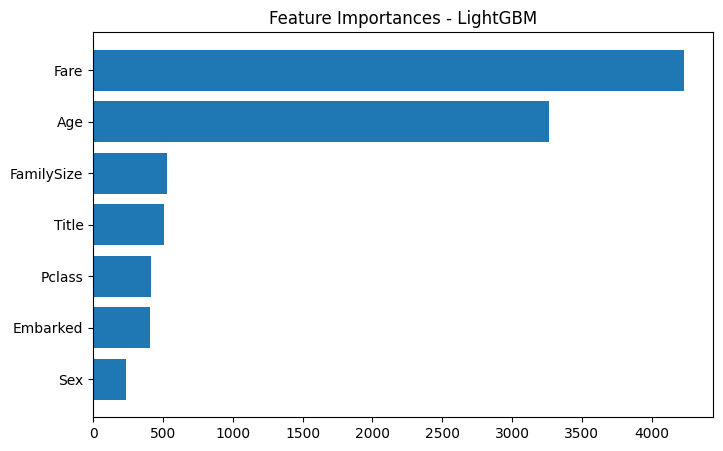


Saved submission_lgb.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [5]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title']
X = full.iloc[:n_train][features].copy()
y = train['Survived'].copy()
X_test = full.iloc[n_train:][features].copy()
print("Training:", X.shape, "Test:", X_test.shape)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
feature_importances = pd.DataFrame()
feature_importances['feature'] = features
NUM_BOOST_ROUND = 500
fold = 0
for tr_idx, val_idx in skf.split(X, y):
    fold += 1
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    train_ds = lgb.Dataset(X_tr, label=y_tr)
    valid_ds = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(
        params,
        train_ds,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[train_ds, valid_ds]
    )
    val_probs = model.predict(X_val)
    val_pred = (val_probs > 0.5).astype(int)
    oof_preds[val_idx] = val_pred
    acc = accuracy_score(y_val, val_pred)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    test_preds += model.predict(X_test) / skf.n_splits
    feature_importances[f'fold_{fold}'] = model.feature_importance()
oof_acc = accuracy_score(y, oof_preds)
print(f"\nOverall OOF Accuracy: {oof_acc:.4f}")
feature_importances['mean'] = feature_importances[[f'fold_{i}' for i in range(1, fold+1)]].mean(axis=1)
feature_importances = feature_importances.sort_values('mean', ascending=False)
print("\nFeature importances:\n", feature_importances[['feature', 'mean']])
plt.figure(figsize=(8,5))
plt.barh(feature_importances['feature'][::-1], feature_importances['mean'][::-1])
plt.title("Feature Importances - LightGBM")
plt.show()
final_pred = (test_preds > 0.5).astype(int)
submission_lgb = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_pred
})
submission_lgb.to_csv("submission_lgb.csv", index=False)
print("\nSaved submission_lgb.csv")
submission_lgb.head()

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import lightgbm as lgb

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

full = pd.concat([train, test], sort=False, ignore_index=True)

full['Embarked'] = full['Embarked'].fillna(full['Embarked'].mode()[0])
full['Sex'] = full['Sex'].map({'male': 0, 'female': 1})
full['Embarked'] = full['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
full['Fare'] = full['Fare'].fillna(full['Fare'].median())
full['Age'] = full['Age'].fillna(full['Age'].median())
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full['IsAlone'] = (full['FamilySize'] == 1).astype(int)
full['Title'] = full['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
rare_titles = full['Title'].value_counts()[full['Title'].value_counts() < 10].index
full['Title'] = full['Title'].replace(rare_titles, 'Rare')
full['Title'] = full['Title'].map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Rare':4}).fillna(4).astype(int)
full['CabinKnown'] = full['Cabin'].notnull().astype(int)
full['TicketPrefix'] = full['Ticket'].str.replace(r'\d+', '', regex=True).str.strip().replace('', 'NONE')
full['TicketPrefix'] = full['TicketPrefix'].astype('category').cat.codes

n_train = train.shape[0]
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'CabinKnown', 'TicketPrefix']
X = full.iloc[:n_train][features]
y = train['Survived']
X_test = full.iloc[n_train:][features]

rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 300], 'max_depth': [4, 6, 8], 'min_samples_split': [2, 5]}
gs = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
print(gs.best_params_)

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'max_depth': 6,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1
}
lgb_oof = np.zeros(len(X))
lgb_test = np.zeros(len(X_test))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr_idx, val_idx in skf.split(X, y):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_valid = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(lgb_params, lgb_train, num_boost_round=300, valid_sets=[lgb_train, lgb_valid])
    lgb_oof[val_idx] = (model.predict(X_val) > 0.5).astype(int)
    lgb_test += model.predict(X_test) / skf.n_splits
print(accuracy_score(y, lgb_oof))

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb.fit(X, y)

vote = VotingClassifier(estimators=[
    ('rf', gs.best_estimator_),
    ('gb', gb)
], voting='soft')
vote.fit(X, y)

final_pred = (lgb_test > 0.5).astype(int)
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_pred
})
submission.to_csv('submission_ensemble.csv', index=False)
print('Saved submission_ensemble.csv')
submission.head()

{'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 100}
0.8484848484848485
Saved submission_ensemble.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
